In [1]:
from torch import nn
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt
import numpy as np

from model import train, test

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# from utils import calculate_dataset_stats

# mean, std = calculate_dataset_stats('/path/to/cleaned/data')
# print(f"TRAINING | Mean: {mean}, Std: {std}")

# mean, std = calculate_dataset_stats('/path/to/cleaned/data')
# print(f"TESTING | Mean: {mean}, Std: {std}")

In [ ]:
train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(p=0.5), # tumor on the left can also be on the right
     transforms.RandomRotation(degrees=10), # patients aren't always laying perfectly straight
     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.95, 1.05)), # attempt to make the model independent from how image is cropped 
     transforms.ColorJitter(brightness=0.1, contrast=0.1), # differences in scaners
     transforms.ToTensor(),
     transforms.Normalize((0.2744, 0.2744, 0.2744), (0.1941, 0.1941, 0.1941))]
)

# test data without augmentation
test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.2828, 0.2828, 0.2829), (0.2020, 0.2020, 0.2020))]
)

batch_size = 32

trainset = ImageFolder('/path/to/cleaned/data', transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = ImageFolder('/path/to/cleaned/data/', transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

classes = ('glioma', 'meningioma', 'notumor', 'pituitary')

In [4]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.20685208..2.2681203].


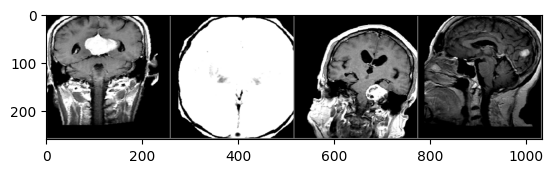

meningioma notumor meningioma meningioma


In [5]:
def imshow(img):
    img = img / 2 + 0.5    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images[:4]))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [6]:
from cnn import SimpleCNN, TweakedSimpleCNN, InceptionCNN
import torch.optim as optim

simple_cnn = SimpleCNN()
tweaked_simple_cnn = TweakedSimpleCNN()
inception_cnn = InceptionCNN()

In [7]:
loss_fn = nn.CrossEntropyLoss()

---
<h3> Base CNN </h3>
convolution -> max pooling -> convolution -> max pooling -> avg pooling -> dense -> dense

In [8]:
simple_cnn.to(device)

SimpleCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool3): AvgPool2d(kernel_size=5, stride=2, padding=0)
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=14400, out_features=128, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [9]:
optimizer = optim.Adam(simple_cnn.parameters(), lr=0.001)
train(simple_cnn, train_loader, optimizer, loss_fn, 100, batch_size, device)

[Epoch: 1] Train loss: 29.53 | Train acc: 62.18%
[Epoch: 2] Train loss: 22.29 | Train acc: 72.78%
[Epoch: 3] Train loss: 19.84 | Train acc: 75.79%
[Epoch: 4] Train loss: 18.55 | Train acc: 77.68%
[Epoch: 5] Train loss: 17.41 | Train acc: 79.15%
[Epoch: 6] Train loss: 16.15 | Train acc: 80.78%
[Epoch: 7] Train loss: 15.03 | Train acc: 82.56%
[Epoch: 8] Train loss: 13.89 | Train acc: 84.03%
[Epoch: 9] Train loss: 13.20 | Train acc: 84.93%
[Epoch: 10] Train loss: 12.20 | Train acc: 86.45%
[Epoch: 11] Train loss: 12.70 | Train acc: 84.89%
[Epoch: 12] Train loss: 11.16 | Train acc: 86.75%
[Epoch: 13] Train loss: 11.05 | Train acc: 87.29%
[Epoch: 14] Train loss: 10.39 | Train acc: 87.68%
[Epoch: 15] Train loss: 10.23 | Train acc: 88.11%
[Epoch: 16] Train loss: 10.04 | Train acc: 88.18%
[Epoch: 17] Train loss: 9.36 | Train acc: 88.76%
[Epoch: 18] Train loss: 9.28 | Train acc: 89.11%
[Epoch: 19] Train loss: 8.79 | Train acc: 89.58%
[Epoch: 20] Train loss: 8.37 | Train acc: 90.44%
[Epoch: 21] T


--- Test Results ---
Loss:      0.0896
Accuracy:  97.41%
Precision: 0.9750
Recall:    0.9741
F1 Score:  0.9742


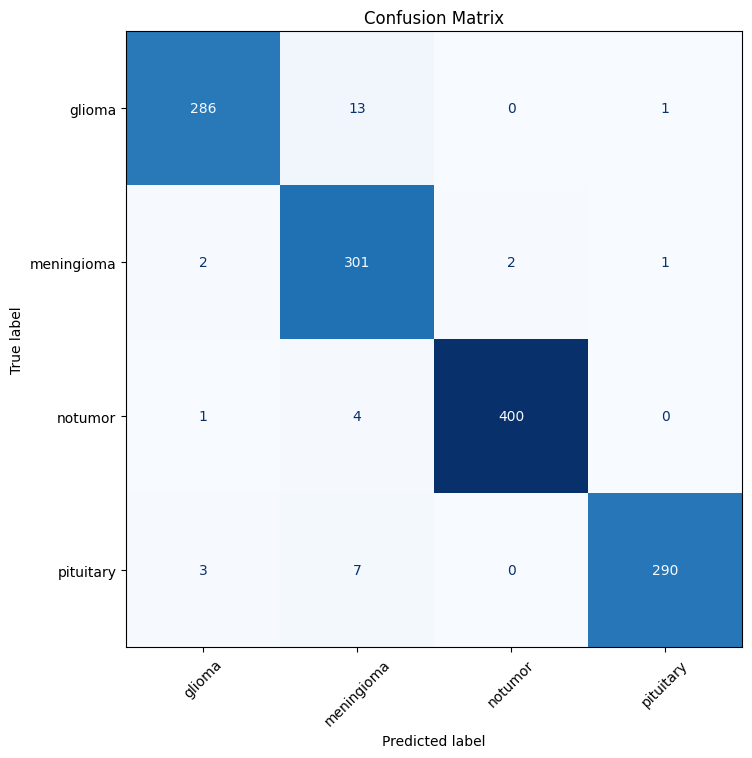

In [10]:
test(simple_cnn, test_loader, loss_fn, device)

---
<h3> Base CNN + Batch norm</h3>
Convolution + batch norm 
    -> max pooling
    -> convolution + batch norm 
    -> max pooling
    -> convolution + batch norm 
    -> max pooling
    -> avg pooling
    -> dense 
    -> dense

In [11]:
tweaked_simple_cnn.to(device)

TweakedSimpleCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (pool3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool4): AvgPool2d(kernel_size=5, strid

In [12]:
optimizer = optim.Adam(tweaked_simple_cnn.parameters(), lr=0.001)
train(tweaked_simple_cnn, train_loader, optimizer, loss_fn, 100, batch_size, device)

[Epoch: 1] Train loss: 55.22 | Train acc: 55.36%
[Epoch: 2] Train loss: 24.16 | Train acc: 69.42%
[Epoch: 3] Train loss: 21.60 | Train acc: 73.46%
[Epoch: 4] Train loss: 20.32 | Train acc: 74.77%
[Epoch: 5] Train loss: 18.61 | Train acc: 77.42%
[Epoch: 6] Train loss: 17.07 | Train acc: 79.67%
[Epoch: 7] Train loss: 16.23 | Train acc: 80.08%
[Epoch: 8] Train loss: 15.12 | Train acc: 82.51%
[Epoch: 9] Train loss: 14.48 | Train acc: 83.12%
[Epoch: 10] Train loss: 13.68 | Train acc: 84.19%
[Epoch: 11] Train loss: 13.32 | Train acc: 84.56%
[Epoch: 12] Train loss: 13.23 | Train acc: 84.66%
[Epoch: 13] Train loss: 12.64 | Train acc: 85.70%
[Epoch: 14] Train loss: 11.80 | Train acc: 86.55%
[Epoch: 15] Train loss: 11.85 | Train acc: 86.40%
[Epoch: 16] Train loss: 11.86 | Train acc: 85.92%
[Epoch: 17] Train loss: 11.65 | Train acc: 86.40%
[Epoch: 18] Train loss: 11.04 | Train acc: 86.85%
[Epoch: 19] Train loss: 10.81 | Train acc: 88.18%
[Epoch: 20] Train loss: 10.74 | Train acc: 87.43%
[Epoch: 2


--- Test Results ---
Loss:      0.2023
Accuracy:  92.22%
Precision: 0.9290
Recall:    0.9222
F1 Score:  0.9222


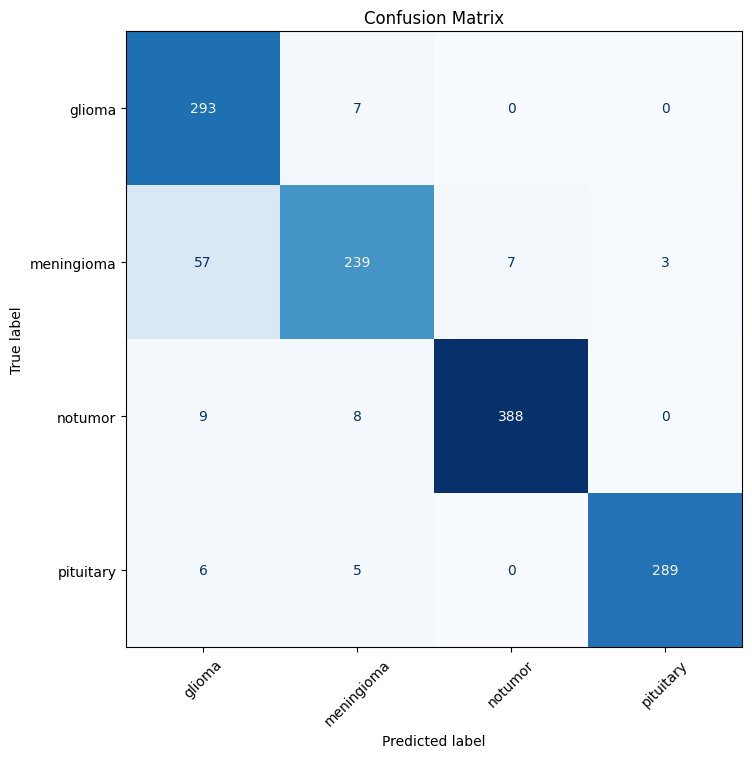

In [13]:
test(tweaked_simple_cnn, test_loader, loss_fn, device)

---
<h3>Inception</h3>

In [14]:
inception_cnn.to(device)

InceptionCNN(
  (conv1): ConvBlock(
    (conv2d): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
    (batchnorm2d): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (inception): InceptionBlock(
    (branch1): ConvBlock(
      (conv2d): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batchnorm2d): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (branch2): Sequential(
      (0): ConvBlock(
        (conv2d): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (batchnorm2d): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (1): ConvBlock(
        (conv2d): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),

In [15]:
optimizer = optim.Adam(inception_cnn.parameters(), lr=0.001)
train(inception_cnn, train_loader, optimizer, loss_fn, 50, batch_size, device)

[Epoch: 1] Train loss: 31.84 | Train acc: 58.47%
[Epoch: 2] Train loss: 27.20 | Train acc: 66.12%
[Epoch: 3] Train loss: 25.68 | Train acc: 68.17%
[Epoch: 4] Train loss: 23.59 | Train acc: 71.71%
[Epoch: 5] Train loss: 22.98 | Train acc: 72.39%
[Epoch: 6] Train loss: 21.00 | Train acc: 75.05%
[Epoch: 7] Train loss: 20.15 | Train acc: 76.66%
[Epoch: 8] Train loss: 19.96 | Train acc: 76.98%
[Epoch: 9] Train loss: 18.55 | Train acc: 79.04%
[Epoch: 10] Train loss: 17.67 | Train acc: 80.09%
[Epoch: 11] Train loss: 17.54 | Train acc: 80.23%
[Epoch: 12] Train loss: 17.15 | Train acc: 80.83%
[Epoch: 13] Train loss: 16.36 | Train acc: 81.44%
[Epoch: 14] Train loss: 16.41 | Train acc: 81.90%
[Epoch: 15] Train loss: 15.68 | Train acc: 82.27%
[Epoch: 16] Train loss: 15.83 | Train acc: 82.06%
[Epoch: 17] Train loss: 15.88 | Train acc: 82.32%
[Epoch: 18] Train loss: 15.12 | Train acc: 82.79%
[Epoch: 19] Train loss: 14.93 | Train acc: 83.77%
[Epoch: 20] Train loss: 14.60 | Train acc: 83.28%
[Epoch: 2


--- Test Results ---
Loss:      0.6257
Accuracy:  77.80%
Precision: 0.7965
Recall:    0.7780
F1 Score:  0.7617


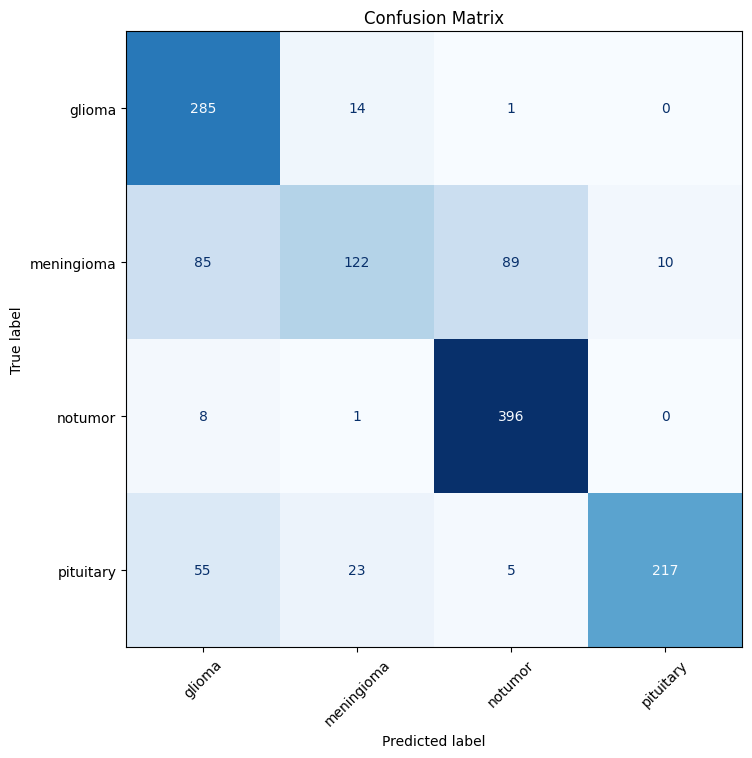

In [16]:
test(inception_cnn, test_loader, loss_fn, device)